## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from LogicalQ.Logical import LogicalCircuit, LogicalStatevector
from LogicalQ.Library.QECCs import steane_code
from LogicalQ.Library.HardwareModels import hardware_models_Quantinuum
from LogicalQ.Execution import execute_circuits

%load_ext autoreload
%autoreload 2

## Demonstrating error correction

In [2]:
# Runs a shot on a noiseless simulator with an error at each of the physical qubits
shots = 1
simulator = AerSimulator()

outputs = []
for i in range(7):
    # Generates the circuit
    lqcirc = LogicalCircuit(2, **steane_code, name="SteaneCodeCircuit")    
    lqcirc.encode([0, 1], max_iterations=1, initial_states=[0, 1])

    # Inserts an error on both logical qubits
    lqcirc.add_error(0, i, 'X') # Can test X or Z errors
    lqcirc.add_error(1, i, 'X')

    # Adds QEC cycle and measurement
    lqcirc.append_qec_cycle([0, 1], perform_flagged_syndrome_measurements=True)
    lqcirc.measure([0, 1], [0, 1], with_error_correction=False)

    # Simulates the QEC cycle
    result = execute_circuits(lqcirc, backend=simulator, shots=shots, memory=True)[0]
    output = result.get_memory(lqcirc)
    outputs.append(output[0][:2])

# Outputs should all be 10 if the error correction worked properly
print(outputs)

['10', '10', '10', '10', '01', '01', '01']


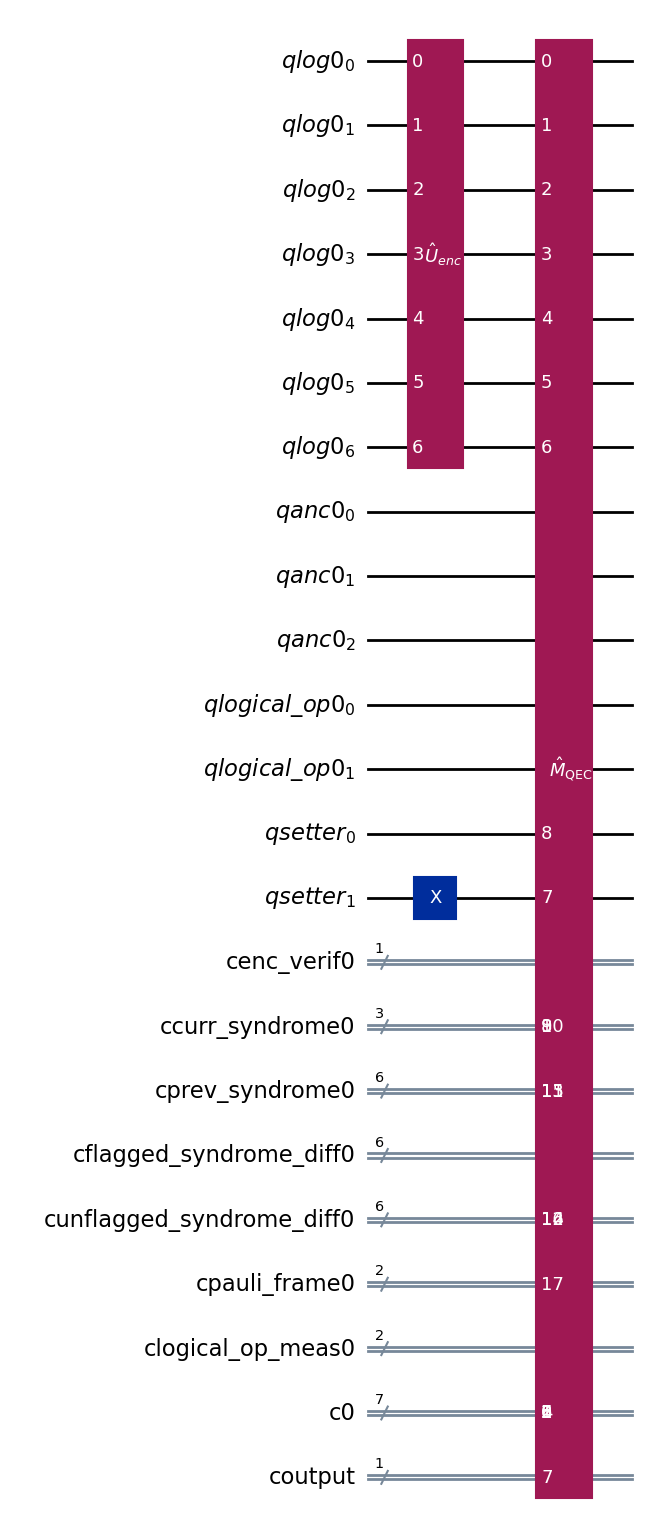

In [3]:
lqcirc = LogicalCircuit(1, **steane_code)
lqcirc.encode([0], max_iterations=0, initial_states=[0])
lqcirc.measure_all(with_error_correction=True)
lqcirc.draw("mpl", fold_qec=True, fold_qed=True, fold_logicalop=False, expr_len=100)

In [4]:
result = execute_circuits(lqcirc, backend=simulator, shots=1024, memory=True)[0]
result.get_counts()

{'0 0110110 00 00 000000 000000 000000 000 0': 118,
 '0 0111001 00 00 000000 000000 000000 000 0': 133,
 '0 1101100 00 00 000000 000000 000000 000 0': 141,
 '0 1011010 00 00 000000 000000 000000 000 0': 107,
 '0 0000000 00 00 000000 000000 000000 000 0': 145,
 '0 1010101 00 00 000000 000000 000000 000 0': 129,
 '0 0001111 00 00 000000 000000 000000 000 0': 124,
 '0 1100011 00 00 000000 000000 000000 000 0': 127}

## Benchmarking encoding verification for SPAM

In [ ]:
from qiskit.visualization import plot_histogram

# Tests SPAM. Accuracy (historically) should be at least 99.3%
initial_state = 0
max_max_it = 3
shots = int(1E5)

backend = "aer_simulator"

fig, ax = plt.subplots()
plot_option = "lsv"
width = 0.3

all_data = []

for max_it in range(0, max_max_it+1):
    lqcirc = LogicalCircuit(1, **steane_code, name="test_circuit")
    lqcirc.encode([0], initial_states=[initial_state], max_iterations=max_it)
    lqcirc.measure_all(with_error_correction=False)
    
    result = execute_circuits(lqcirc, backend=backend, hardware_model=hardware_models_Quantinuum["H2-1"], coupling_map=None, shots=shots)[0]
    physical_counts = result.get_counts()
    logical_counts = lqcirc.get_logical_counts(physical_counts)
    
    if plot_option == "counts":
        data = logical_counts
    elif plot_option == "probs":
        p0 = logical_counts["0"]/shots if "0" in logical_counts else 1-(logical_counts["1"]/shots)
        data = [p0, 1-p0]
    elif plot_option == "lsv":
        lsv = LogicalStatevector.from_counts(physical_counts, 1, **steane_code)
        p0 = np.linalg.norm(lsv.logical_decomposition[0])**2
        data = [p0, 1-p0]
    else:
        raise ValueError(f"'{plot_option}' is not a valid plot_option; choose from ['counts', 'probs', 'lsv']")

    bar = ax.bar(max_it, data[0], width, log=False, label=f"max_iterations={max_it}")
    ax.bar_label(bar)

outcomes = range(1, max_max_it+1)
ax.set_xticks(outcomes)

ax.set_yscale("log")

ax.set_title("Encoding verification test")
ax.set_xlabel("Max number of iterations")
ax.set_ylabel(f"N({initial_state})" if plot_option == "counts" else f"P({initial_state})")

plt.show()

## Comparing Hadamard gate implementations

In [ ]:
initial_state = 0
n_gates = 100
increments = 2   # Test every (increment) number of H gates
shots = 1000

lqcirc = LogicalCircuit(2, **steane_code, name="SteaneCodeCircuit")    
lqcirc.encode([0,1], max_iterations=1, initial_states=[0,1])

backend = "aer_simulator"

all_data = []

for max_it in range(n_gates + 1):
    # Create and encode logical circuit
    lqcirc = LogicalCircuit(1, **steane_code, name="test_circuit")
    lqcirc.encode(0, initial_states=[initial_state])

    # Append H gates max_it times on logical qubit 0
    for _ in range(max_it * increments):   # Add a +1 in the range constructor to test odd numbers of gates
        lqcirc.h(0)

    # Measure 
    lqcirc.measure([0], [0], with_error_correction=False)

    # Simulate
    result = execute_circuits(lqcirc, backend=backend, hardware_model=hardware_models_Quantinuum["H2-1"], coupling_map=None, shots=shots, memory=True)[0]
    output = result.get_memory(lqcirc)
    all_data.append(output)

In [ ]:
accuracies = []
for output in all_data:
    log_counts = lqcirc.get_logical_counts(output)
    acc = log_counts['0'] / (log_counts['0'] + log_counts['1'])
    accuracies.append(acc)

h_gates_applied = range(0, (n_gates + 1) * increments, increments)
plt.plot(h_gates_applied, accuracies, 'o--')
plt.xlabel('Number of H gates applied')
plt.ylabel('Rate of Measured 0')
plt.show()

## Appending QEC cycles on demand

In [ ]:
lqcirc = LogicalCircuit(1, **steane_code)
lqcirc.encode(0, initial_states=[1])
lqcirc.append_qec_cycle([0])
#lqcirc.draw('mpl')

## Constructing LogicalCircuits from physical QuantumCircuits

In [ ]:
# We can also construct a logical circuit from a physical qubit circuit, first by constructing a QuantumCircuit:
pqc = QuantumCircuit(2)
pqc.x(0)
# pqc.h(0)
# pqc.cx(0,1)
pqc.draw(output="mpl")

In [ ]:
# Then, we convert the QuantumCircuit to a LogicalCircuit:
lqc = LogicalCircuit.from_physical_circuit(pqc, **steane_code)
lqc.draw(output="mpl")